In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer, DefaultDataCollator
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomRotation, RandomResizedCrop, RandomHorizontalFlip, RandomAdjustSharpness, Resize, ToTensor
from PIL import ImageFile
from pathlib import Path
from tqdm import tqdm
import os

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
from transformers import ViTForImageClassification, ViTImageProcessor, pipeline

# Diretório onde o modelo foi salvo
model_dir = "deepfake_vs_real_image_detection"

# Carregar o modelo salvo
model = ViTForImageClassification.from_pretrained(model_dir)
processor = ViTImageProcessor.from_pretrained(model_dir)

In [7]:
# Definir transformações
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    ToTensor(),
    normalize
])
_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

# Função para preparar os dados em batch para o treinamento do modelo
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


[{'label': 'Fake', 'score': 0.9966703057289124}, {'label': 'Real', 'score': 0.003329728962853551}]


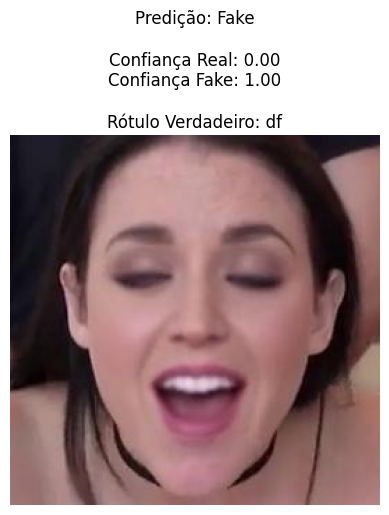

In [8]:
# Criação do pipeline para classificação de imagens

# - 'model_name': O nome do modelo pré-treinado a ser usado para a classificação de imagem
# - 'device': Especifica o dispositivo a ser usado para executar o modelo (0 para GPU, -1 para CPU).

pipe = pipeline('image-classification', model=model, feature_extractor=processor, device=-1)

# Função para exibir a imagem com o resultado da classificação
def show_image_with_result(image, result, true_label):
    confidences = {res['label']: res['score'] for res in result}
    conf_real = confidences.get('Real', 0)
    conf_fake = confidences.get('Fake', 0)
    
    plt.imshow(image)
    plt.title(f"Predição: {result[0]['label']}\n\nConfiança Real: {conf_real:.2f}\nConfiança Fake: {conf_fake:.2f}\n\nRótulo Verdadeiro: {true_label}")
    plt.axis('off')
    plt.show()

# Trecho para acessar uma imagem do conjunto e exibir o seu resultado
example = test_data[39]
image = example["image"]
true_label = id2label[example["label"]]
result = pipe(image)
print(result)

show_image_with_result(image, result, true_label)

[{'label': 'Fake', 'score': 0.9952746629714966}, {'label': 'Real', 'score': 0.004725370090454817}]


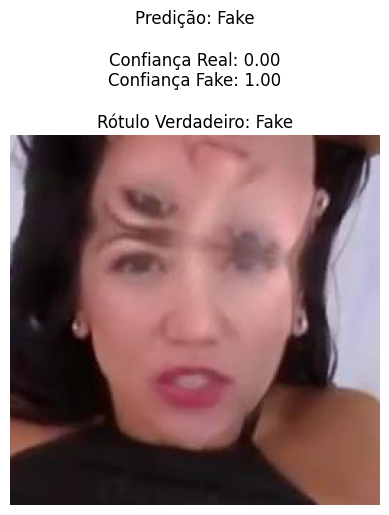

In [96]:
example = test_data[]
image = example["image"]
true_label = id2label[example["label"]]
result = pipe(image)
print(result)

show_image_with_result(image, result, true_label)

100%|██████████████████████████████████████████████████████████████████████████████| 6906/6906 [20:10<00:00,  5.71it/s]


Acurácia: 0.8350709527946713
              precision    recall  f1-score   support

        Real       0.78      0.93      0.85      3453
        Fake       0.91      0.74      0.82      3453

    accuracy                           0.84      6906
   macro avg       0.85      0.84      0.83      6906
weighted avg       0.85      0.84      0.83      6906



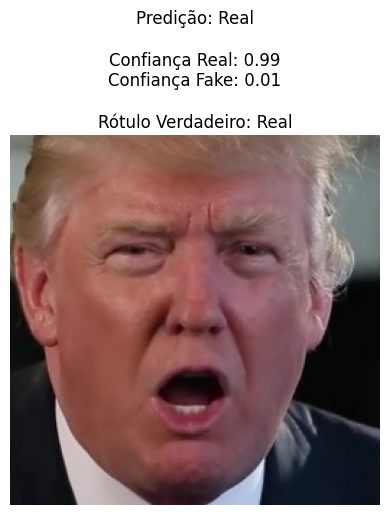

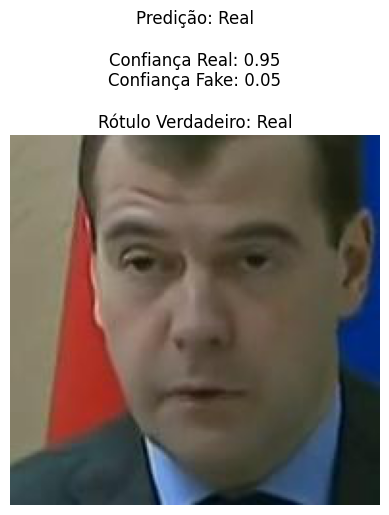

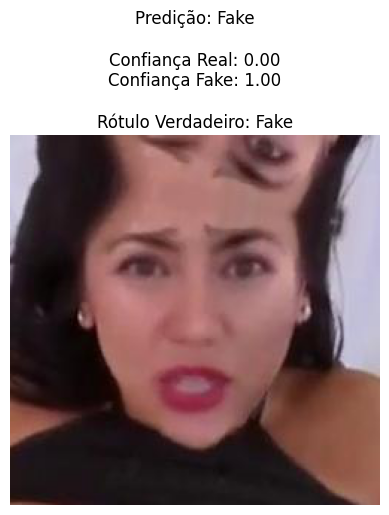

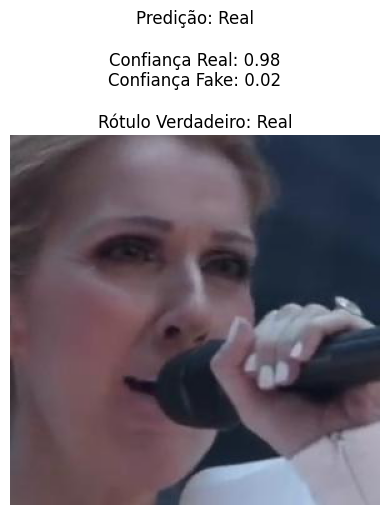

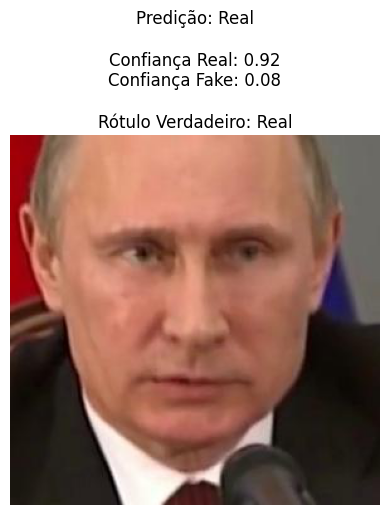

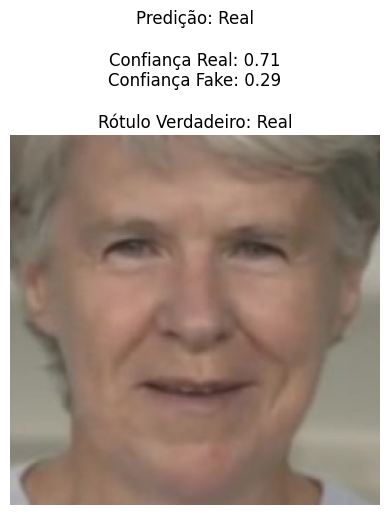

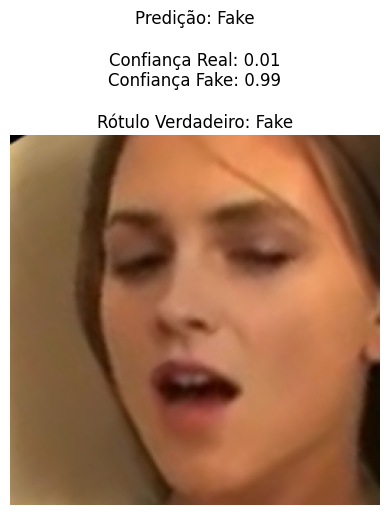

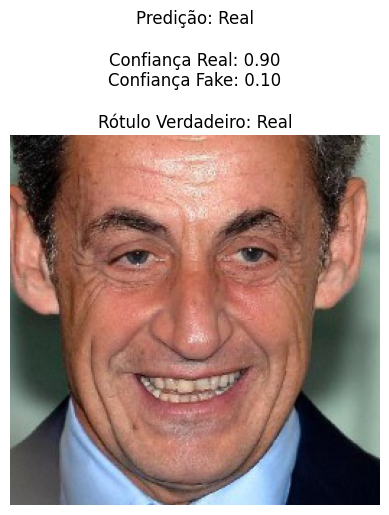

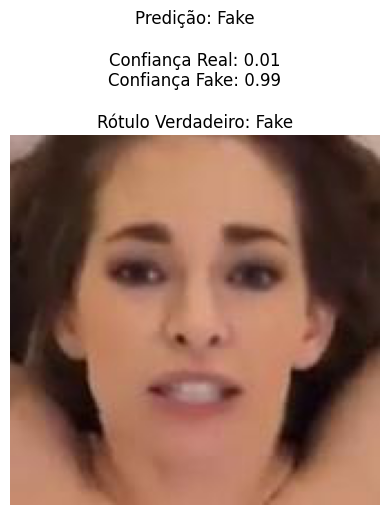

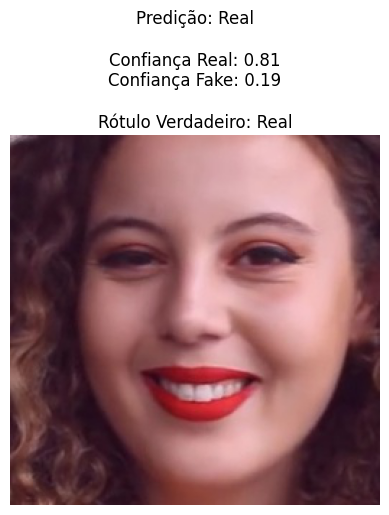

In [44]:
# Inferência sobre todo o conjunto de teste
results = []
true_labels = []
images = []

for example in tqdm(test_data):
    image = example["image"]
    true_label = id2label[example["label"]]
    result = pipe(image)
    predicted_label = result[0]['label']
    
    results.append(predicted_label)
    true_labels.append(true_label)
    images.append((image, result, true_label))

# Avaliar os resultados
accuracy = accuracy_score(true_labels, results)
print(f"Acurácia: {accuracy}")

print(classification_report(true_labels, results, target_names=labels_list))

# Exibir algumas imagens com os resultados
for img, res, true_lbl in images[:10]:  # Mostrar apenas as 10 primeiras imagens
    show_image_with_result(img, res, true_lbl)